In [1]:
pip install imutils

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25854 sha256=51b09a1db5bd21e193a4cf09f6106aa3e6f2c9e1e170b016284131441a75d8dc
  Stored in directory: c:\users\administrator\appdata\local\pip\cache\wheels\c2\02\32\f3617a9f68bcc67eda3ebeb4514eba18f62e81ff439428109d
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D, Dropout , Flatten , Dense, Input

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input # Normalization
from tensorflow.keras.preprocessing.image import img_to_array,load_img
from tensorflow.keras.utils import to_categorical # convert vector to matrix
from sklearn.preprocessing import LabelBinarizer # encoding
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

# from tensorflow.keras.models import load_model
# from imutils.viedeo import VideoStream # To open the camera
# import numpy as np
# import imutils
# import time
# import cv2
# import os

In [2]:
INIT_LR = 1e-4 # initial learninig rate (0.00001)
EPOCHS = 20    # numberof epochs
BS = 32        # bathc size

### Import data and spliting into two categories

In [3]:
DIRECTORY = r"G:\Computer Vision Projects\Face mask detection\data"
CATEGORIES = ["with_mask", "without_mask"]

In [4]:
DIRECTORY = r"G:\Computer Vision Projects\Face mask detection\data"
CATEGORIES = ["with_mask", "without_mask"]

print("[info] loading images.....")

data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path): # convert image names into list
        img_path = os.path.join(path , img)
        image = load_img(img_path , target_size = (224,224)) # size to adabt on mobilev2
        image = img_to_array(image) # convert image to array to pass to neural network
        image = preprocess_input(image) # Normaliztion of theimage
        
        # load images and labels
        data.append(image)
        labels.append(category)

[info] loading images.....


C:\Users\Administrator\anaconda3\lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [5]:
# perform ont-hot encoding on labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels) # convert labels from vector to matrix

data = np.array(data, dtype = "float32")
labels = np.array(labels)


### Split data

In [6]:
(X_train , x_test , Y_train , y_test) = train_test_split(data , labels, test_size = 0.20, stratify= labels , random_state= 42)

### Modify images

In [7]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

### Load mobileNetv2 Model ensuring that the head FC layer are left off
- **We remove the last FC layer and we will add our own output layers arichtictuer**
- **ensure the head FC layer are left off**

In [8]:
baseModel = MobileNetV2(weights="imagenet" , include_top= False,
                       input_tensor=Input(shape = (224, 224 , 3)))

**construct the head of the model that will be replaced on the top of our base model**

In [9]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name = "flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)                  # Avoid Overfitting
headModel = Dense(2 , activation="softmax")(headModel) # only two classes (with mask  - without mask)

### The final Model (baseModel + headModel)

In [10]:
model = Model(inputs = baseModel.input , outputs = headModel)

Freeze the layers of base model (mobilVNet) to stop updating the weights and use the old weights

In [11]:
for layer in baseModel.layers:
    layer.trainable = False

### Compile the model

In [12]:
print("[info] compiling model...")

# opt = Adam(lr = INIT_LR, dacay = INIT_LR / EPOCHS) # Decay to converge learning rate

opt = Adam(lr = INIT_LR)

model.compile(loss = "binary_crossentropy", optimizer = opt, metrics=["accuracy"])

[info] compiling model...


### Train the head of the model

In [19]:
print("[info] training head...")

H = model.fit(
    aug.flow(X_train,Y_train,batch_size = BS), # apply data generator on trainning data,
    steps_per_epoch = len(X_train) // BS, # apply batch size on our data,
    validation_data = (x_test , y_test),
    validation_steps = len(x_test) // BS,
    epochs = EPOCHS)

[info] training head...
Epoch 1/20



188/188 [==============================] - ETA: 0s - loss: 0.0873 - accuracy: 0.9704WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 47 batches). You may need to use the repeat() function when building your dataset.


188/188 [==============================] - 199s 1s/step - loss: 0.0873 - accuracy: 0.9704 - val_loss: 0.0470 - val_accuracy: 0.9848
Epoch 2/20
188/188 [==============================] - 155s 825ms/step - loss: 0.0471 - accuracy: 0.9835
Epoch 3/20
188/188 [==============================] - 158s 838ms/step - loss: 0.0455 - accuracy: 0.9845
Epoch 4/20
188/188 [==============================] - 157s 836ms/step - loss: 0.0345 - accuracy: 0.9885
Epoch 5/20
188/188 [==============================] - 158s 841ms/step - loss: 0.0358 - accuracy: 0.9874
Epoch 6/20
188/188 [==============================] - 158s 840ms/step - loss: 0.0320 - accuracy: 0.9882
Epoch 7/20
188/188 [==============================] - 158s 841ms/step - loss: 0.0310 - accuracy: 0.9903
Epoch 8/20
188/188 [==============================] - 159s 847ms/step - loss: 0.0273 - accuracy: 0.9907
Epoch 9/20
188/188 [==============================] - 165s 876ms/step - loss: 0.0282 - accuracy: 0.9894
Epoch 10/20
188/188 [===============

**check on trainable layers**

In [20]:
for l in model.layers:
    print(l.name, l.trainable)

input_1 False
Conv1 False
bn_Conv1 False
Conv1_relu False
expanded_conv_depthwise False
expanded_conv_depthwise_BN False
expanded_conv_depthwise_relu False
expanded_conv_project False
expanded_conv_project_BN False
block_1_expand False
block_1_expand_BN False
block_1_expand_relu False
block_1_pad False
block_1_depthwise False
block_1_depthwise_BN False
block_1_depthwise_relu False
block_1_project False
block_1_project_BN False
block_2_expand False
block_2_expand_BN False
block_2_expand_relu False
block_2_depthwise False
block_2_depthwise_BN False
block_2_depthwise_relu False
block_2_project False
block_2_project_BN False
block_2_add False
block_3_expand False
block_3_expand_BN False
block_3_expand_relu False
block_3_pad False
block_3_depthwise False
block_3_depthwise_BN False
block_3_depthwise_relu False
block_3_project False
block_3_project_BN False
block_4_expand False
block_4_expand_BN False
block_4_expand_relu False
block_4_depthwise False
block_4_depthwise_BN False
block_4_depthwi

## Prediction

In [21]:
print("[info] Evaluating network...")
predIdxs = model.predict(x_test , batch_size = BS)

predIdxs = np.argmax(predIdxs , axis = 1)

[info] Evaluating network...
48/48 [==============================] - 21s 441ms/step


**classification report**

In [22]:
print(classification_report(y_test.argmax(axis = 1), predIdxs,
                           target_names = lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      0.99      0.99       745
without_mask       0.99      0.99      0.99       766

    accuracy                           0.99      1511
   macro avg       0.99      0.99      0.99      1511
weighted avg       0.99      0.99      0.99      1511



## Saving the model

In [23]:
print("[info] saving mask detector model...")

model.save("mask_detector.model" , save_format = "h5")

[info] saving mask detector model...


C:\Users\Administrator\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plot the training loss and accuracy

ValueError: x and y must have same first dimension, but have shapes (20,) and (1,)

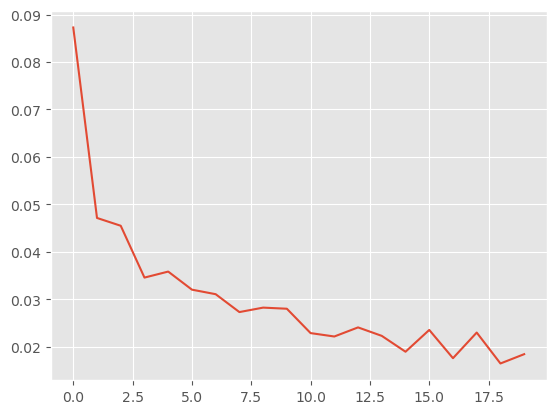

In [27]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label = "train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label = "val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label = "train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label = "val_acc")

plt.title("Training Loss and Accuracy")

plt.xlable("# Eploch ")
plt.ylable("Loss/Accuracy")
plt.legend(loc = "lower left")
plt.savefig("plot.png")